In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from imblearn import over_sampling, under_sampling

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

%matplotlib inline


print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.20.1
pandas version :  1.2.4
seaborn version :  0.11.1


In [2]:
df_mentah = pd.read_csv('flight.csv')
df_mentah.head(2)

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31.0,3/31/2014,...,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
1,28065,2/19/2007,8/3/2007,Male,6,NaN,beijing,CN,42.0,3/31/2014,...,167434.0,293678,3/25/2014,7,5.194245,17,29,1.252314,415768,33


# Stage 1

## Data Cleansing

### Delete Column

In [3]:
df_mentah.drop(['MEMBER_NO','WORK_CITY', 'WORK_PROVINCE', 'LOAD_TIME', 'FIRST_FLIGHT_DATE', 'LAST_FLIGHT_DATE'], axis=1, inplace=True)

### Convert Data type to datetime

In [4]:
df_mentah['FFP_DATE'] = df_mentah['FFP_DATE'].astype('datetime64[ns]').dtypes

### Delete 1 value columns

In [5]:
drop_col = []
for i,j in enumerate(df_mentah.nunique()==1):
    if j == True:
        print(i)
        drop_col.append(df_mentah.columns[i])

df_mentah.drop(drop_col, axis=1, inplace=True)

0


### Missing value

In [6]:
df_mentah.isna().sum()

GENDER               3
FFP_TIER             0
WORK_COUNTRY        26
AGE                420
FLIGHT_COUNT         0
BP_SUM               0
SUM_YR_1           551
SUM_YR_2           138
SEG_KM_SUM           0
LAST_TO_END          0
AVG_INTERVAL         0
MAX_INTERVAL         0
EXCHANGE_COUNT       0
avg_discount         0
Points_Sum           0
Point_NotFlight      0
dtype: int64

In [7]:
df_mentah.dropna(inplace=True)

### Duplicate Data

In [8]:
df_mentah.duplicated().sum()

1

In [9]:
df_mentah.drop_duplicates(keep='first', inplace=True)

### Outliers

In [10]:
# mengambil kolom numerik

# numerik
num_dtypes = ['int64','float64']
num_df = df_mentah.select_dtypes(num_dtypes)
numerik = num_df.columns

In [11]:
df_mentah[numerik].describe()

,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
count,61855.000000,61855.000000,61855.000000,61855.000000,61855.000000,61855.000000,61855.000000,61855.000000,61855.000000,61855.000000,61855.000000,61855.000000,61855.000000,61855.000000
mean,4.103452,42.491149,11.964562,11041.633482,5374.989642,5662.172937,17304.011462,172.600162,68.155923,167.464150,0.324194,0.721651,12681.856212,2.759470
std,0.375835,9.887630,14.116122,16394.566697,8124.009475,8702.772421,21040.381611,181.227990,77.684340,123.154321,1.143996,0.184793,20597.613331,7.406292
min,4.000000,6.000000,2.000000,0.000000,0.000000,0.000000,368.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,35.000000,3.000000,2591.000000,1020.000000,833.000000,4867.000000,29.000000,23.750000,81.000000,0.000000,0.612660,2848.000000,0.000000
50%,4.000000,41.000000,7.000000,5801.000000,2816.000000,2827.000000,10183.000000,105.000000,45.000000,144.000000,0.000000,0.711828,6442.000000,0.000000
75%,4.000000,48.000000,15.000000,12975.500000,6600.000000,6912.000000,21498.000000,260.000000,82.500000,229.000000,0.000000,0.808828,14457.500000,1.000000
max,6.000000,110.000000,213.000000,505308.000000,239560.000000,234188.000000,580717.000000,731.000000,728.000000,728.000000,46.000000,1.500000,985572.000000,140.000000


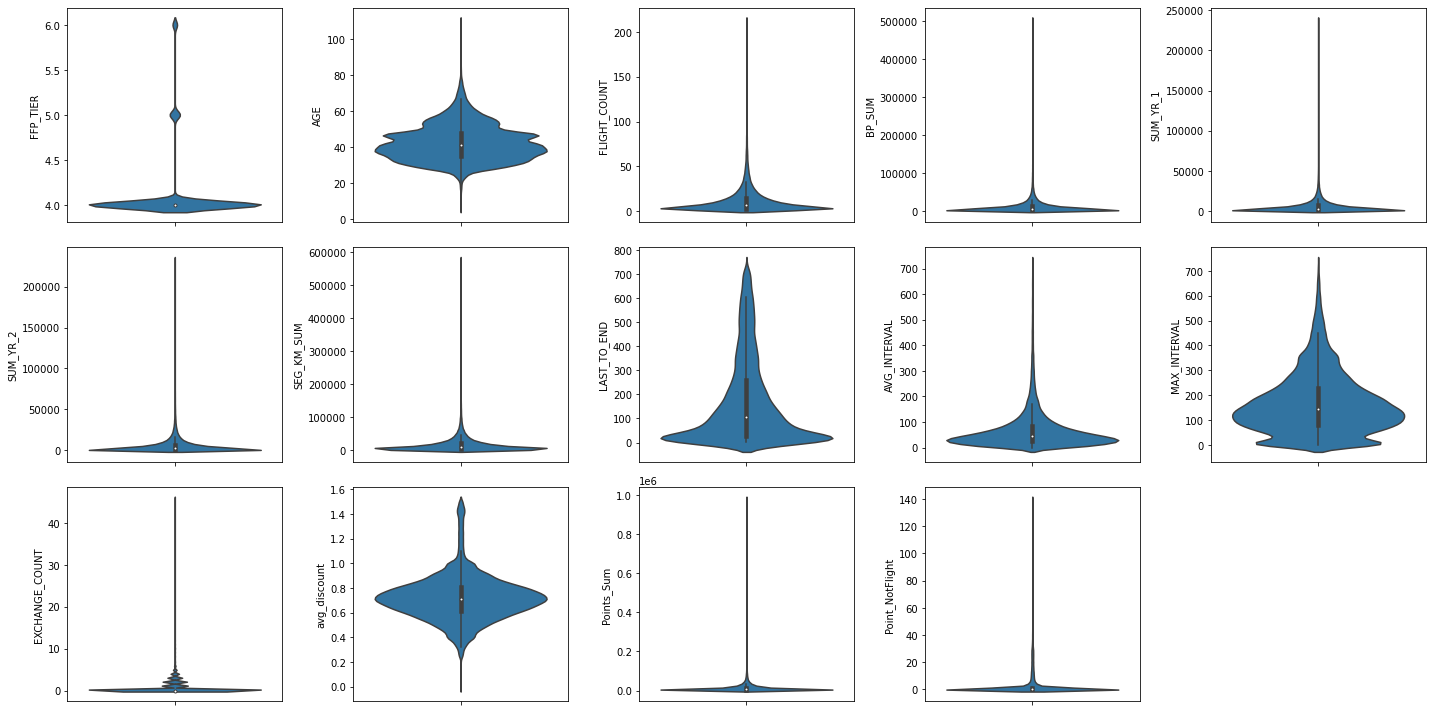

In [12]:
plt.figure(figsize=(20,10))

for i in range(0, len(numerik)):
    plt.subplot(3, round(len(numerik)/3), i+1)
    sns.violinplot(y=df_mentah[numerik[i]], orient='v')
    plt.tight_layout()


In [13]:
# # Menghapus outlier berdasarkan Z-score (Rating saja)
# print(f'Jumlah baris sebelum memfilter outlier: {len(df_mentah)}')

# filtered_entries = np.array([True] * len(df_mentah))

# for col in numerik:
#     zscore = abs(stats.zscore(df_mentah[col])) # hitung absolute z-scorenya
#     filtered_entries = (zscore < 3) & filtered_entries # keep yang kurang dari 3 absolute z-scorenya
#     # print(f'Jumlah baris setelah memfilter outlier: {len(df_mentah)}')
    
# df_zscore = df_mentah[filtered_entries] # filter, cuma ambil yang z-scorenya dibawah 3

# print(f'Jumlah baris setelah memfilter outlier: {len(df_zscore)}')

In [14]:
# plt.figure(figsize=(20,10))

# for i in range(0, len(numerik)):
#     plt.subplot(3, round(len(numerik)/3), i+1)
#     sns.violinplot(y=df_zscore[numerik[i]], orient='v')
#     plt.tight_layout()


In [15]:
print(f'Jumlah baris sebelum memfilter outlier: {len(df_mentah)}')

filtered_entries = np.array([True] * len(df_mentah))
for col in numerik:
    Q1 = df_mentah[col].quantile(0.25)
    Q3 = df_mentah[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    filtered_entries = ((df_mentah[col] >= low_limit) & (df_mentah[col] <= high_limit)) & filtered_entries
    
df_iqr = df_mentah[filtered_entries]

print(f'Jumlah baris setelah memfilter outlier: {len(df_iqr)}')

Jumlah baris sebelum memfilter outlier: 61855
Jumlah baris setelah memfilter outlier: 34617


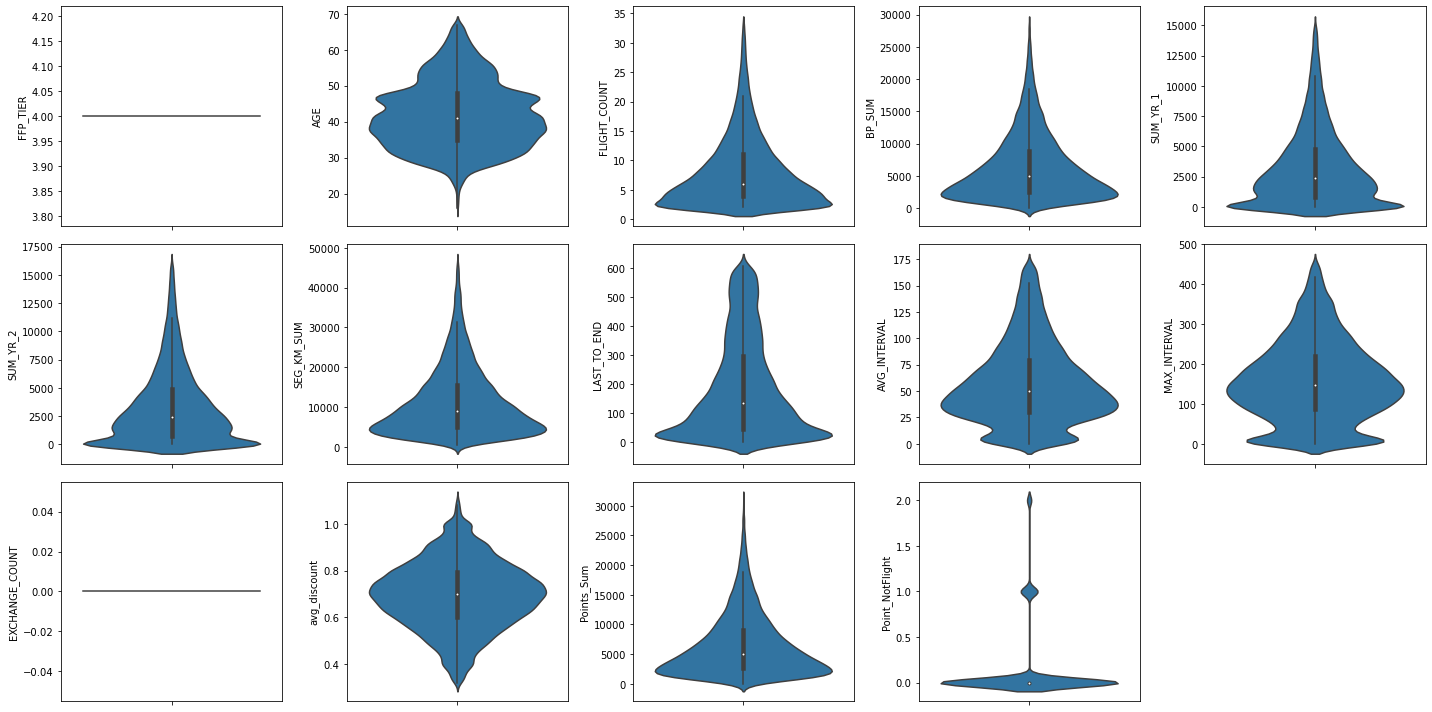

In [16]:
plt.figure(figsize=(20,10))

for i in range(0, len(numerik)):
    plt.subplot(3, round(len(numerik)/3), i+1)
    sns.violinplot(y=df_iqr[numerik[i]], orient='v')
    plt.tight_layout()


In [17]:
# for i in df_iqr.columns:
#     print(i, ':', len(df_iqr[i].unique()))
df_iqr.nunique()==1

GENDER             False
FFP_TIER            True
WORK_COUNTRY       False
AGE                False
FLIGHT_COUNT       False
BP_SUM             False
SUM_YR_1           False
SUM_YR_2           False
SEG_KM_SUM         False
LAST_TO_END        False
AVG_INTERVAL       False
MAX_INTERVAL       False
EXCHANGE_COUNT      True
avg_discount       False
Points_Sum         False
Point_NotFlight    False
dtype: bool

In [18]:
drop_col = []
for i,j in enumerate(df_iqr.nunique()==1):
    if j == True:
        print(i)
        drop_col.append(df_iqr.columns[i])

df_iqr.drop(drop_col, axis=1, inplace=True)

1
12


### Feature/Label Encoding

In [19]:
# # mengambil kolom kategori
cat_dtypes = ['object']
cat_df = df_iqr.select_dtypes(cat_dtypes)
kategori = cat_df.columns

df_iqr[kategori].describe()

,GENDER,WORK_COUNTRY
count,34617,34617
unique,2,93
top,Male,CN
freq,26140,31650


In [20]:
for i in kategori:
    df_iqr[i+'_label']= LabelEncoder().fit_transform(df_iqr[i])

### Normalization/Standardization

In [21]:
# mengambil kolom numerik

# numerik
num_dtypes = ['int32', 'int64','float64']
num_df = df_iqr.select_dtypes(num_dtypes)
numerik = num_df.columns

In [22]:
df_standar = StandardScaler().fit_transform(df_iqr['avg_discount'].values.reshape(len(df_iqr), 1))
df_standar = pd.DataFrame(df_standar, columns=['avg_discount'])

In [23]:
normalisasi = df_iqr[numerik].columns != 'avg_discount'
normalisasi = numerik[normalisasi]

df_normalisasi = MinMaxScaler().fit_transform(df_iqr[normalisasi])
df_normalisasi = pd.DataFrame(df_normalisasi, columns=normalisasi)

In [24]:
df_scaler = pd.concat([df_normalisasi, df_standar], axis=1)
df_scaler.head()

,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,Points_Sum,Point_NotFlight,GENDER_label,WORK_COUNTRY_label,avg_discount
0,0.686275,0.129032,0.789596,0.624582,0.580452,0.981601,0.404959,0.532551,0.527716,0.722954,0.0,1.0,0.163043,0.438801
1,0.647059,0.774194,0.984976,0.333734,0.880040,0.982036,0.033058,0.156012,0.243902,0.901845,0.0,1.0,0.163043,0.377037
2,0.803922,0.129032,0.986380,0.000000,0.949320,0.959288,0.297521,0.205279,0.248337,0.903130,0.0,1.0,0.163043,0.477948
3,0.921569,0.838710,0.978939,0.699733,0.761827,0.941412,0.224793,0.127729,0.166297,0.922800,1.0,1.0,0.163043,0.577452
4,0.588235,0.967742,0.994805,0.869606,0.952503,0.936997,0.016529,0.136222,0.270510,0.910844,0.0,1.0,0.163043,0.578264


### Export Data to CSV

In [25]:
df_iqr.to_csv("df_iqr.csv", index=False)
df_scaler.to_csv("df_scaler.csv", index=False)